<a href="https://colab.research.google.com/github/rajy4683/S12EVA4/blob/master/S12EVA4_ImgNet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!nvidia-smi

Sun Apr 19 11:46:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [17]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys

Mounted at /content/drive


### Dependencies


In [0]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

In [0]:
!pip install -U git+https://github.com/albu/albumentations

#### WANDB client login

In [6]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
sys.path.append('/content/drive/My Drive/EVA4/')
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')

In [0]:
%load_ext autoreload

In [0]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/EVA4/tiny_imagenet/ti2/ti201/train.zip', 'r') as zipObj:
    # Extract all the contents of zip file in different directory
    zipObj.extractall('/content/t2')

In [0]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/EVA4/tiny_imagenet/ti2/ti201/val.zip', 'r') as zipObj:
    # Extract all the contents of zip file in different directory
    zipObj.extractall('/content/t2')

In [0]:
!cp /content/drive/My\ Drive/EVA4/tiny_imagenet/ti2/ti201/w*txt /content/t2/

In [12]:
%autoreload 2
from RekogNizer import lrfinder
from RekogNizer import traintest
from RekogNizer import logger
from RekogNizer import fileutils
from RekogNizer import basemodelclass
from RekogNizer import dataloader
from RekogNizer import dataloader

from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg,PadIfNeeded,Flip, IAAFliplr,
)
from albumentations.pytorch import ToTensor


from RekogNizer import hyperparams
# hyper_param_values = {
#                       "lr":0.21694816106338752,
#                       "dropout":0.1, 
#                       "momentum":0.7062620648684866, 
#                       "epochs":100, 
#                       "weight_decay":0.00015753761358641488
#                       }
#hyperparams.set_hyperparam(hyper_param_values)
torch.manual_seed(hyperparams.hyperparameter_defaults['seed'])    


  pip install torch-lr-finder -v --global-option="amp"


In [23]:
import torch
import torchvision
#import torchvision.transforms as transforms
from RekogNizer import hyperparams
from RekogNizer import dataloader
from RekogNizer import traintest
from RekogNizer import basemodelclass

# from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
# from albumentations import (
#     HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
#     Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg,
# )
# from albumentations.pytorch import ToTensor
# import random

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import os
import sys
import numpy as np

if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle
model_new2 = basemodelclass.S11ResNet()
summary(model_new2.to(torch.device("cuda")),input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,728
        MaxPool2d-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [14]:
train_path = "/content/drive/My Drive/EVA4/tiny_imagenet/ti2/ti202/train"
test_path="/content/drive/My Drive/EVA4/tiny_imagenet/ti2/ti201/val"
trainloader, testloader = dataloader.get_imagenet_loaders(train_path, test_path, transform_train=None, transform_test=None)

Compose([
  Cutout(always_apply=True, p=1, num_holes=1, max_h_size=8, max_w_size=8),
  IAAFliplr(always_apply=False, p=0.5),
  RandomBrightnessContrast(always_apply=True, p=1, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}) Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [26]:
!python  /content/drive/My\ Drive/EVA4/RekogNizer/train_s12_new.py -p '{"lr":0.015084, "ocp_max_lr":0.5, "anneal_strategy":"cos","div_factor":128,"final_div_factor":64, "momentum":0.85, "epochs":24, "weight_decay":0.0009,"batch_size":512}'

  pip install torch-lr-finder -v --global-option="amp"
Setting  lr  =  0.015084
Setting  ocp_max_lr  =  0.5
Setting  anneal_strategy  =  cos
Setting  div_factor  =  128
Setting  final_div_factor  =  64
Setting  momentum  =  0.85
Setting  epochs  =  24
Setting  weight_decay  =  0.0009
Setting  batch_size  =  512
Final Hyperparameters
             dropout : 0.1 
          batch_size : 512 
     test_batch_size : 128 
                  lr : 0.015084 
            momentum : 0.85 
             no_cuda : False 
                seed : 1 
              epochs : 24 
                bias : False 
      sched_lr_gamma : 0.5 
       sched_lr_step : 1 
            start_lr : 0 
        weight_decay : 0.0009 
  lr_decay_threshold : 0.0 
              factor : 0.0 
             project : news5 
          ocp_max_lr : 0.5 
    final_div_factor : 64 
          div_factor : 128 
     anneal_strategy : cos 
           pct_start : 0.208 
      cycle_momentum : False 
           lr_policy : ocp 
          

### Accuracy Plots


In [0]:
from RekogNizer import traintest
from RekogNizer import logger
from RekogNizer import fileutils
from RekogNizer import basemodelclass
from RekogNizer import dataloader

import pandas as pd
import numpy as np
import torch

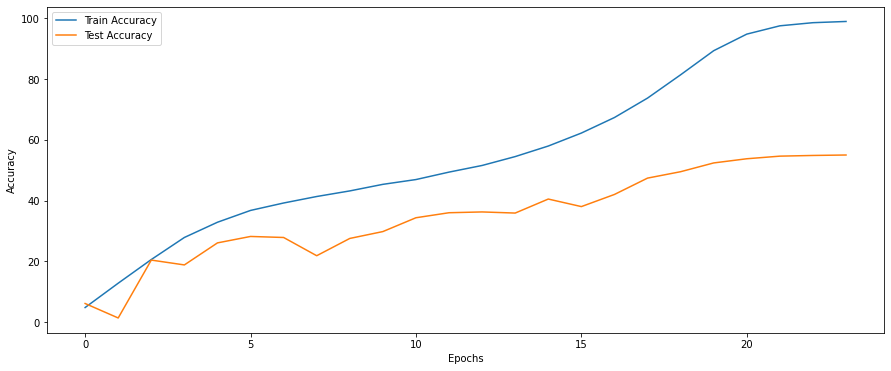

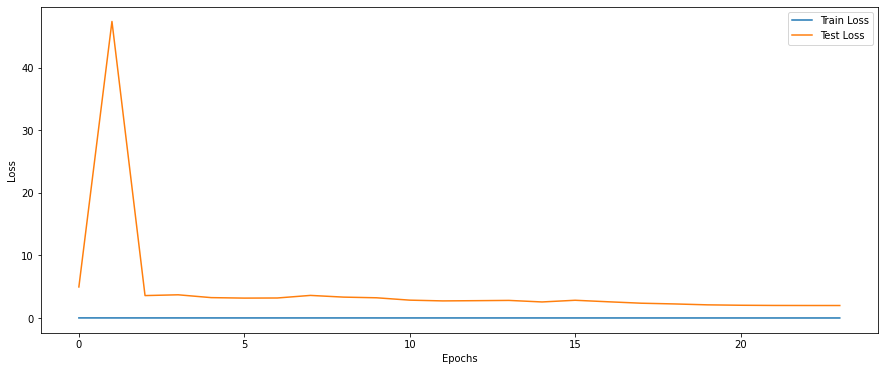

In [29]:
run_list = ['rajy4683/news5/runs/12aovjno']
runs_df = logger.get_wandb_dataframes(run_list=run_list)#(project="rajy4683/news5",count=1)
new_df = pd.DataFrame().append(runs_df)


fileutils.plot_graphs([new_df],
            ['Train Accuracy', 'Test Accuracy'],
            columns=['Train Accuracy', 'Test Accuracy'],
            xlabel="Epochs",
            ylabel="Accuracy")

fileutils.plot_graphs([new_df],
            ['Train Loss', 'Test Loss'],
            columns=['Train Loss', 'Test Loss'],
            xlabel="Epochs",
            ylabel="Loss")

### LR Plot

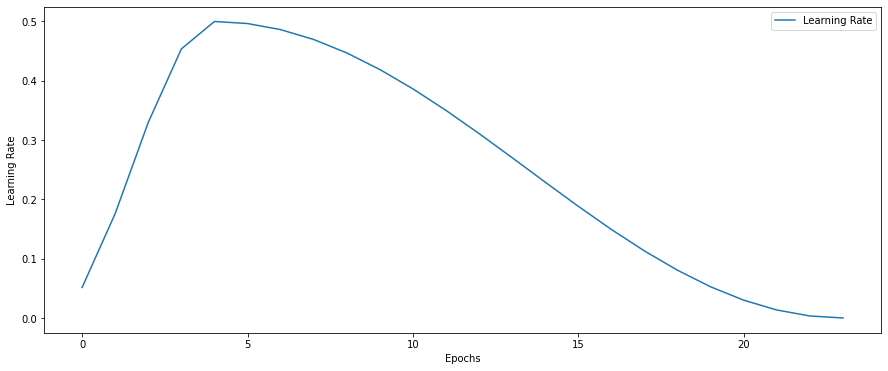

In [30]:
fileutils.plot_graphs([new_df],
            ['Learning Rate'],
            columns=['Learning Rate'],
            xlabel="Epochs",
            ylabel="Learning Rate")

### Validation Results

In [35]:
%load_ext autoreload
%autoreload 2
from RekogNizer import traintest
from RekogNizer import basemodelclass

import torchvision.transforms as transforms
import torchvision

#my_model,acc = traintest.model_builder2(basemodelclass.ResNet18(), weights_path="/content/drive/My Drive/EVA4/model_saves/model-23b3505819.h5")
#my_model,acc = traintest.model_builder2(basemodelclass.ResNet18(), weights_path="/content/drive/My Drive/EVA4/model_saves/model-15ad50e1bc.h5", local_device=torch.device("cpu"))
#my_model,acc = traintest.model_builder2(basemodelclass.ResNet18(), weights_path="/content/drive/My Drive/EVA4/model_saves/model-2fba2384bd.h5", local_device=torch.device("cpu"))
my_model,acc = traintest.model_builder2(basemodelclass.S11ResNet(), weights_path="/content/drive/My Drive/EVA4/model_saves/model-1f88fee686.h5", local_device=torch.device("cpu"))

#class_accuracy_dict = traintest.classwise_accuracy(my_model, testloader, classes, device=torch.device("cpu"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from RekogNizer import imgnetloader
imgnetloader.get_id_dictionary("/content/t2").keys()
#imgnetloader.get_class_to_id_dict("/content/t2")

dict_keys(['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n02669723', 'n04465501', '

In [37]:
from RekogNizer import hyperparams

from RekogNizer import imgnetloader
# transform_test = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                     download=True, transform=transform_test)
# testloader = dataloader.get_dataloader(testset, hyperparams.hyperparameter_defaults['batch_size'], shuffle=False, num_workers=2)

#trainloader, testloader = dataloader.get_train_test_dataloader_cifar10()
trainloader, testloader = dataloader.get_imagenet_loaders(train_path, test_path, transform_train=None, transform_test=None)
class_accuracy_dict = traintest.classwise_accuracy(my_model, 
                                                   testloader, 
                                                   list(imgnetloader.get_id_dictionary("/content/t2").keys()), 
                                                   device=torch.device("cuda"))

Compose([
  Cutout(always_apply=True, p=1, num_holes=1, max_h_size=8, max_w_size=8),
  IAAFliplr(always_apply=False, p=0.5),
  RandomBrightnessContrast(always_apply=True, p=1, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}) Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Accuracy of n02124075 : 39 %
Accuracy of n04067472 : 26 %
Accuracy of n04540053 : 52 %
Accuracy of n04099969 : 55 %
Accuracy of n07749582 : 70 %
Accuracy of n01641577 : 68 %
Accuracy 

<BarContainer object of 200 artists>

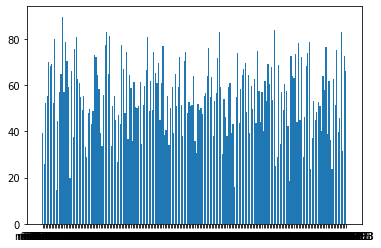

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar([key for key in class_accuracy_dict.keys()],[val for val in class_accuracy_dict.values()])

### Misclassified Images

14886
(14886,)
54.89090909090909 2.0000593391187262


<Figure size 720x720 with 0 Axes>

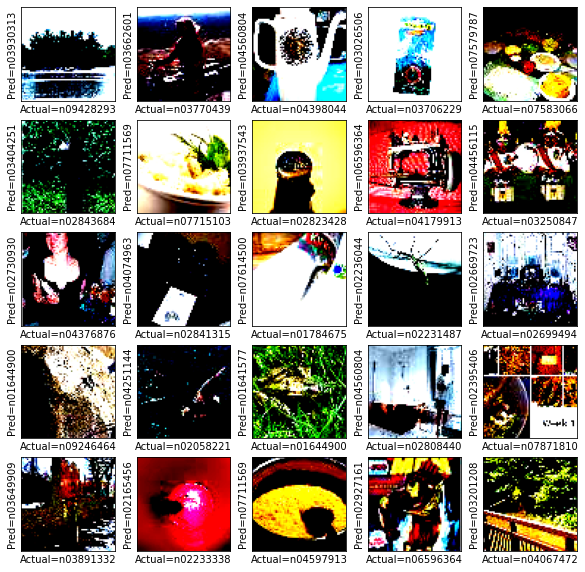

In [39]:
from RekogNizer import traintest
type(my_model)
classes = dataloader.classes
#trainloader, testloader = dataloader.get_train_test_dataloader_cifar10()
classes = list(imgnetloader.get_id_dictionary("/content/t2").keys())
error_images, preds, actuals = traintest.show_misclassfied_images(my_model, testloader, classes)


### GRADCAM Visualizations

In [0]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from RekogNizer.gradcam2 import *

saliency_map size : torch.Size([4, 4])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])


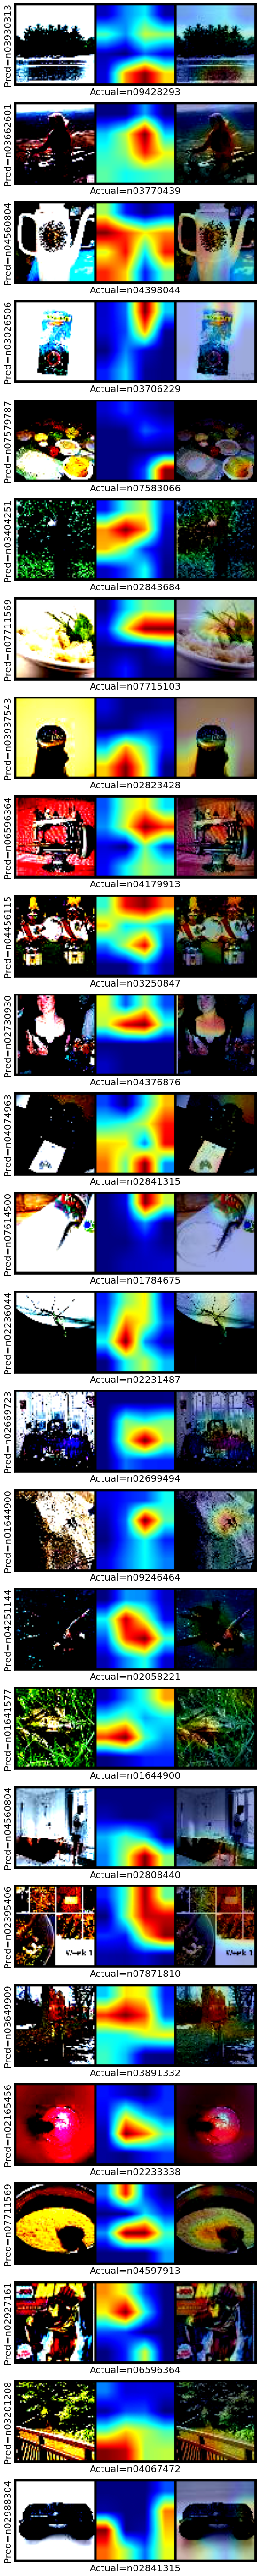

In [47]:
resnet_model_dict = dict(type='resnet', arch=my_model.to(torch.device("cpu")), layer_name='layer3', input_size=(64, 64))
mean=[0.4827, 0.4724, 0.4427]
std=[0.2482, 0.2501, 0.2698]

#classes[np.int(preds[idx])], xlabel="Actual="+classes[np.int(actuals[idx])]
classes = list(imgnetloader.get_id_dictionary("/content/t2").keys())
#dataloader.classes

#gradcam_images = []
fig = plt.figure(figsize=(100,100))
idx = 0
for elem in zip(error_images[:26], actuals[:26], preds[:26]):
    ax = fig.add_subplot(26, 1, idx+1, xticks=[], yticks=[])
    idx+=1
    npimg= visualize_gradcam_image(resnet_model_dict,
                            elem[0], 
                            classes[np.int(elem[1])], 
                            classes[np.int(elem[2])], 
                            mean=mean, std=std)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xlabel(xlabel="Actual="+classes[np.int(elem[1])],fontsize=20)
    ax.set_ylabel(ylabel="Pred="+classes[np.int(elem[2])],fontsize=20)
                  #xlabel="Actual="+classes[np.int(elem[1])],fontdict=)
fig.savefig('/content/drive/My Drive/EVA4/gradcam_s10eva4.jpg')